In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'UBI.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,714,-194,520,-3,238,73,21,426,138,...,94,122,65,417,63,529,343,-27,107.34,2014-05-15
1,2014-09-30,484,-106,378,12,164,21,39,339,139,...,102,0,145,370,63,494,191,-28,113.29,2014-10-30
2,2015-03-31,980,-231,749,75,657,24,18,830,130,...,95,0,183,436,276,773,464,-28,113.29,2015-05-15
3,2015-09-30,207,-53,154,-75,273,27,50,472,125,...,108,0,159,376,275,714,-99,-24,114.19,2015-10-30
4,2016-03-31,1187,-252,935,169,461,420,19,1057,106,...,206,0,228,662,277,1002,440,-18,114.19,2016-05-15


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
16,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,1882,4959,157,61,589,1480,1134,3152,576,-46
17,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,2069,5027,154,83,640,1645,1187,3240,452,-42
18,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,1776,4671,123,26,110,739,2062,3192,238,-30
19,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,2004,4753,144,0,665,1283,1567,3174,219,-23
20,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,2075,5121,157,0,427,1057,2082,3242,319,-93


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
16,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,4959,157,61,589,1480,1134,3152,576,-46,0.891125
17,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
18,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
19,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
20,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
16,2022-03-31,2022-05-15,127.32,1374,-166,1208,78,1453,471,22,...,4959,157,61,589,1480,1134,3152,576,-46,0.891125
17,2022-09-30,2022-10-30,121.14,731,-81,650,-190,1530,313,44,...,5027,154,83,640,1645,1187,3240,452,-42,0.992853
18,2023-03-31,2023-05-15,121.14,1083,-135,948,-305,1491,268,19,...,4671,123,26,110,739,2062,3192,238,-30,0.932003
19,2023-09-30,2023-10-30,147.34,836,-88,748,-35,1305,342,22,...,4753,144,0,665,1283,1567,3174,219,-23,0.918837
20,2024-03-31,2024-05-15,147.34,1465,-116,1349,192,1205,746,9,...,5121,157,0,427,1057,2082,3242,319,-93,0.920544


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr, report='half-year')

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr, report='half-year')

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-19,14.410,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.604929,0.395071,0.0,0.0,0.0,0.0,0.728291,-0.004202,0.0,0.0
1,2014-05-26,14.655,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.604929,0.395071,0.0,0.0,0.0,0.0,0.728291,-0.004202,0.0,0.0
2,2014-06-02,15.055,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.604929,0.395071,0.0,0.0,0.0,0.0,0.728291,-0.004202,0.0,0.0
3,2014-06-09,14.515,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.604929,0.395071,0.0,0.0,0.0,0.0,0.728291,-0.004202,0.0,0.0
4,2014-06-16,14.385,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.604929,0.395071,0.0,0.0,0.0,0.0,0.728291,-0.004202,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr, report='half-year')
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-19,14.410,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.0,0.728291,-0.004202,0.0,0.0,inf,1.909592,1.083172,1.286953,inf
1,2014-05-26,14.655,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.0,0.728291,-0.004202,0.0,0.0,inf,1.942059,1.101588,1.305370,inf
2,2014-06-02,15.055,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.0,0.728291,-0.004202,0.0,0.0,inf,1.995066,1.131655,1.335437,inf
3,2014-06-09,14.515,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.0,0.728291,-0.004202,0.0,0.0,inf,1.923506,1.091065,1.294846,inf
4,2014-06-16,14.385,2014-03-31,714.0,0.0,7.546115,107.34,0.0,0.0,238.0,...,0.0,0.728291,-0.004202,0.0,0.0,inf,1.906279,1.081293,1.285074,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

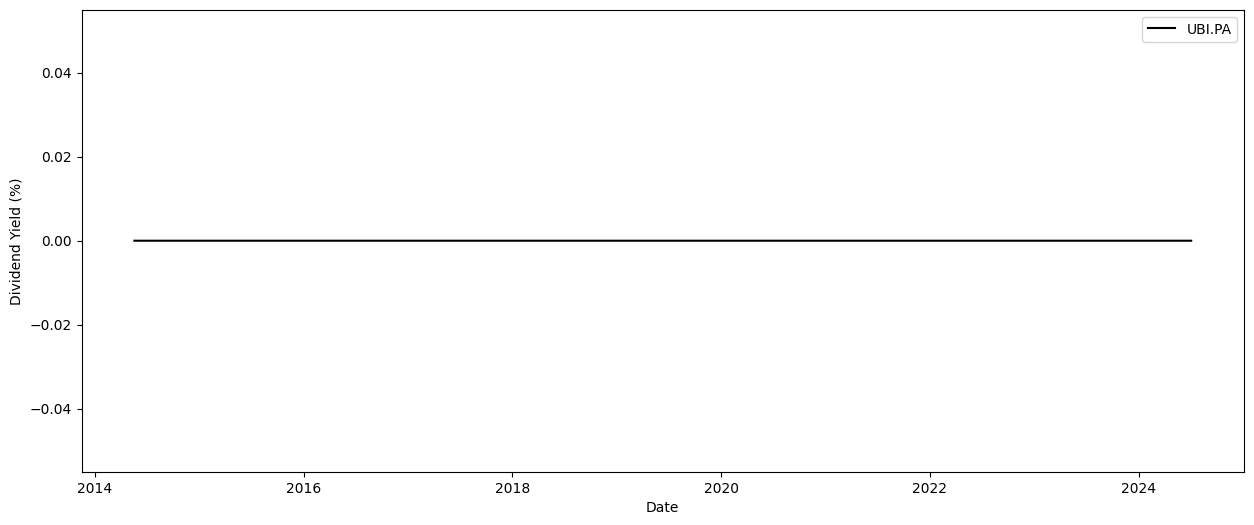

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.22646
share_price      1.00000
Name: share_price, dtype: float64


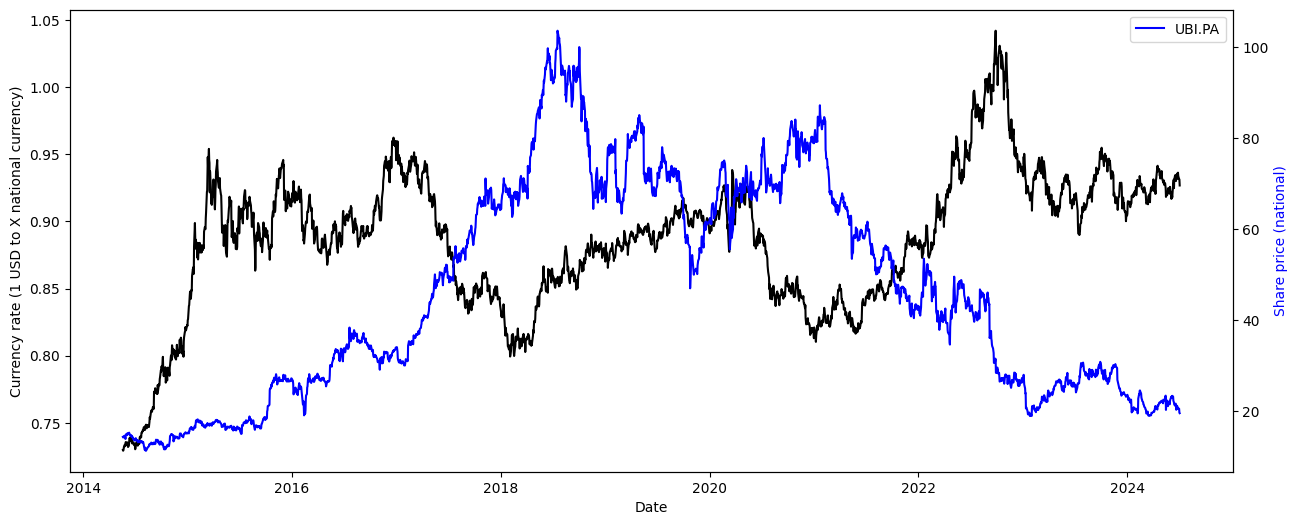

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

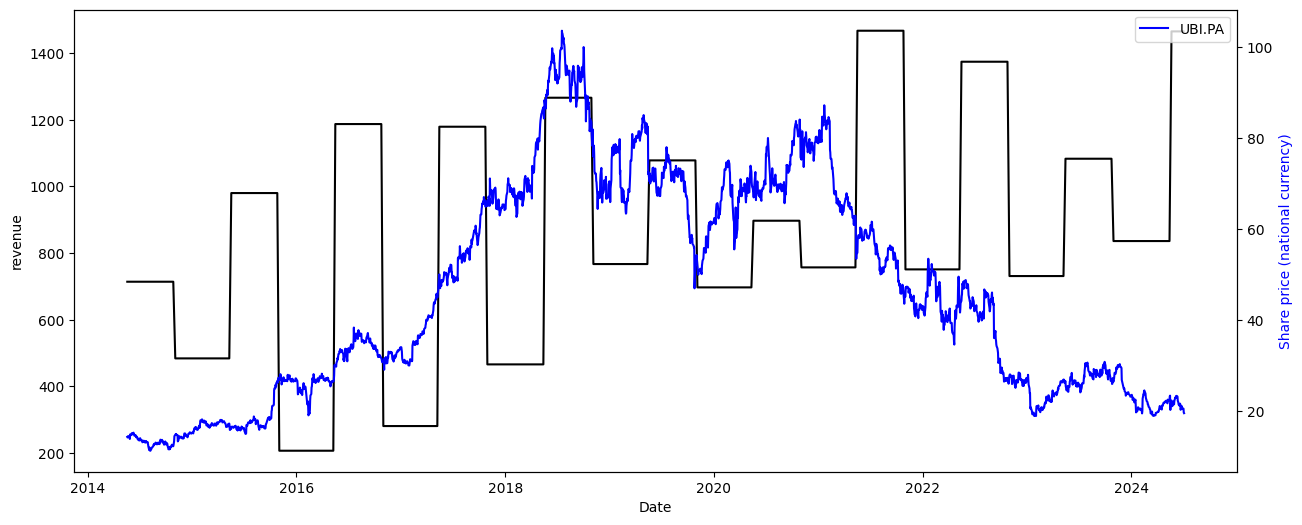

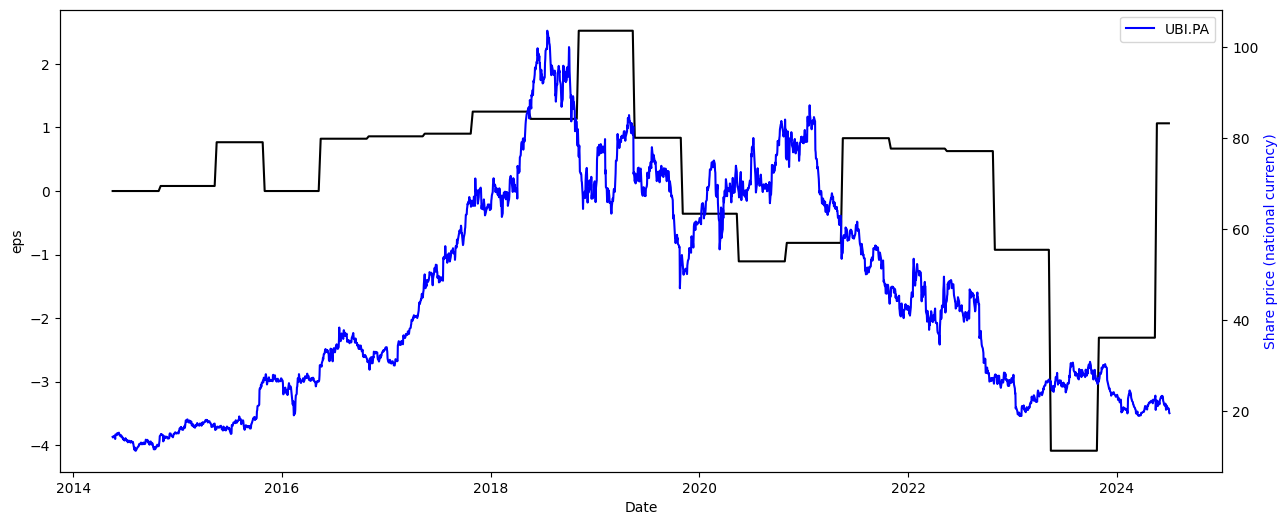

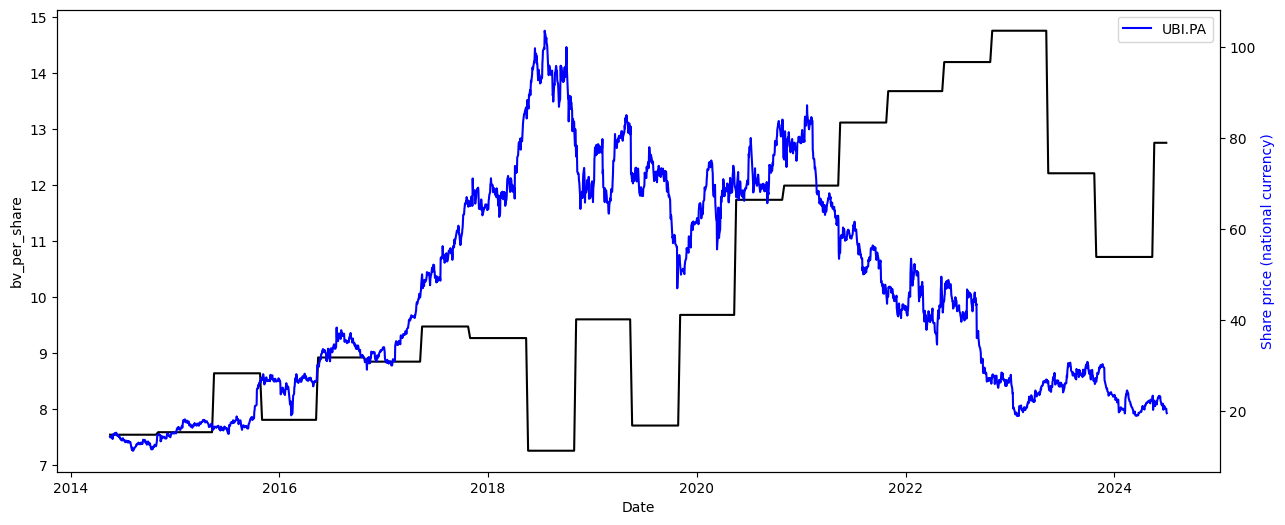

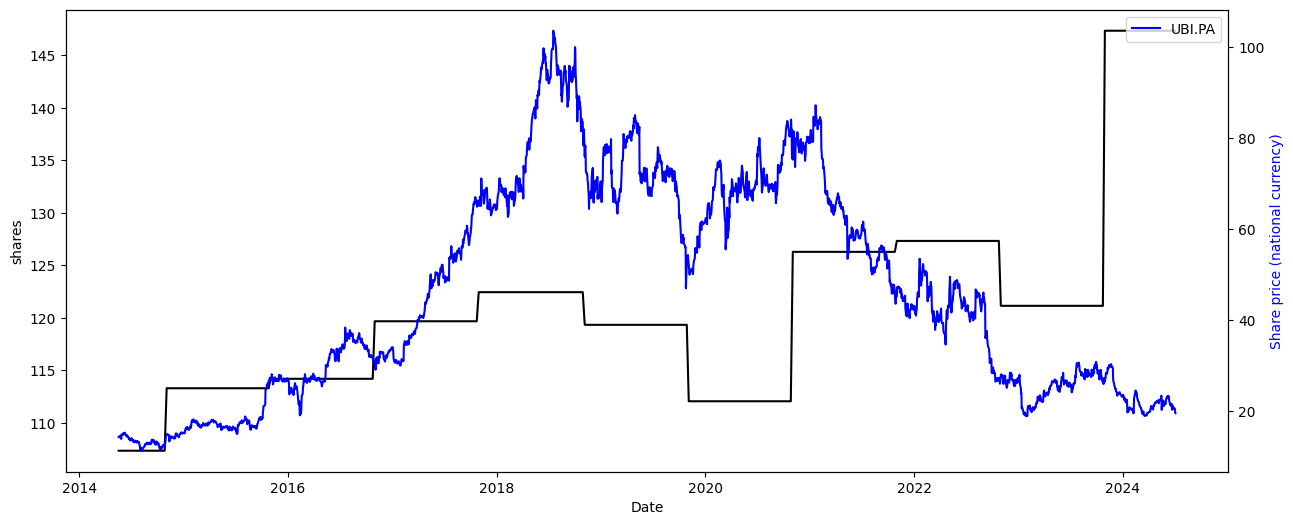

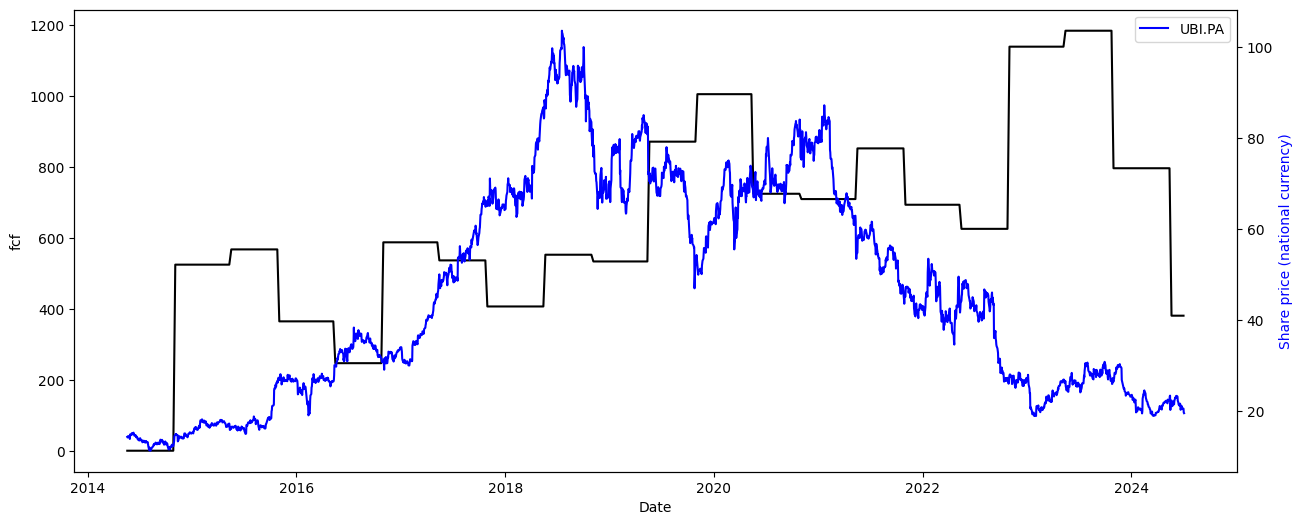

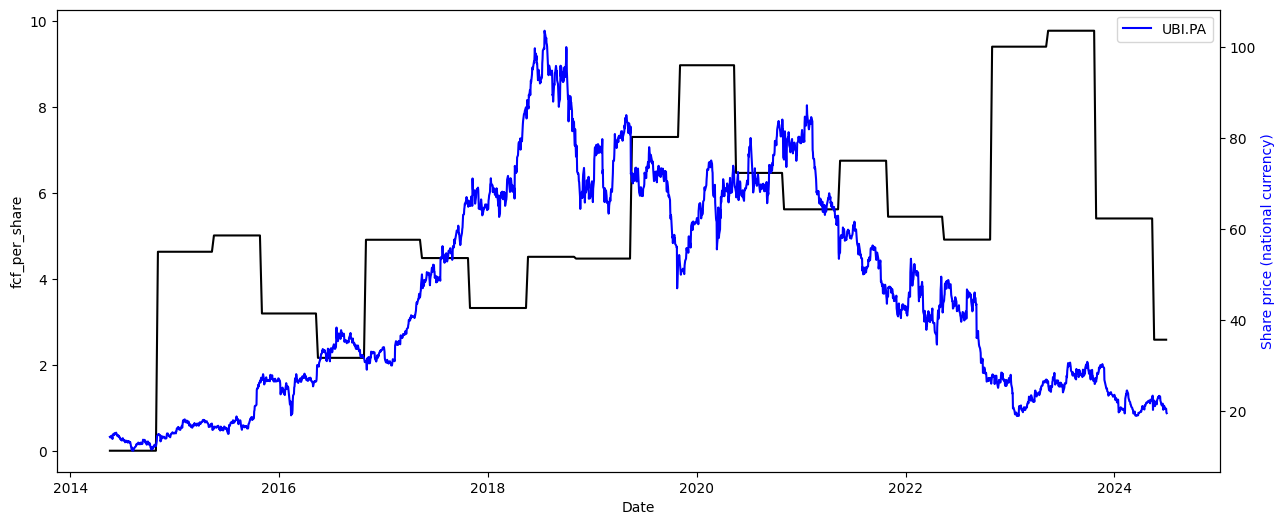

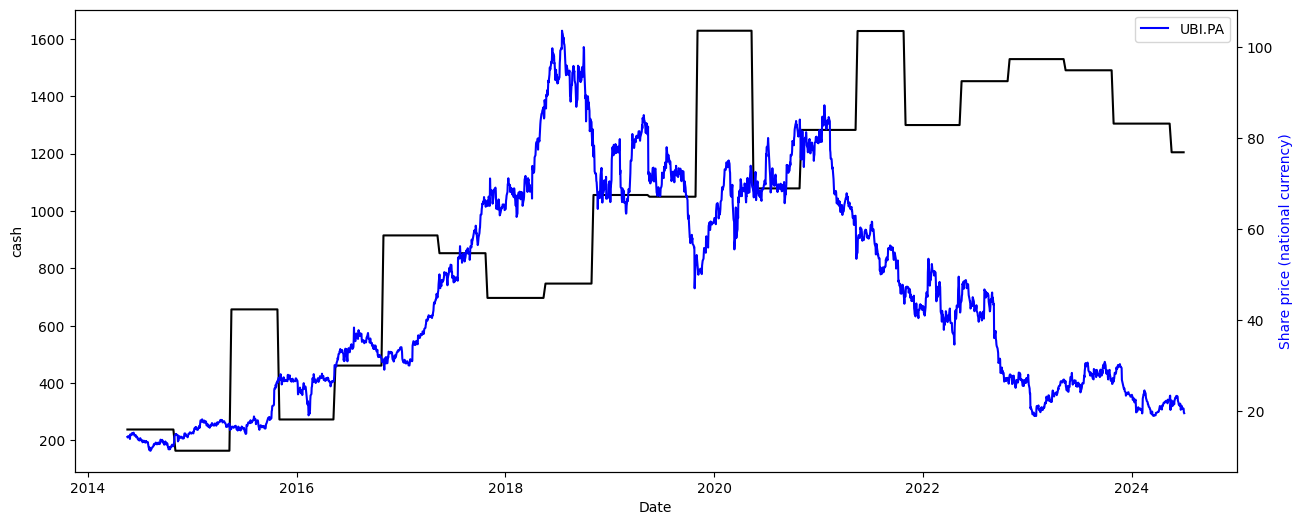

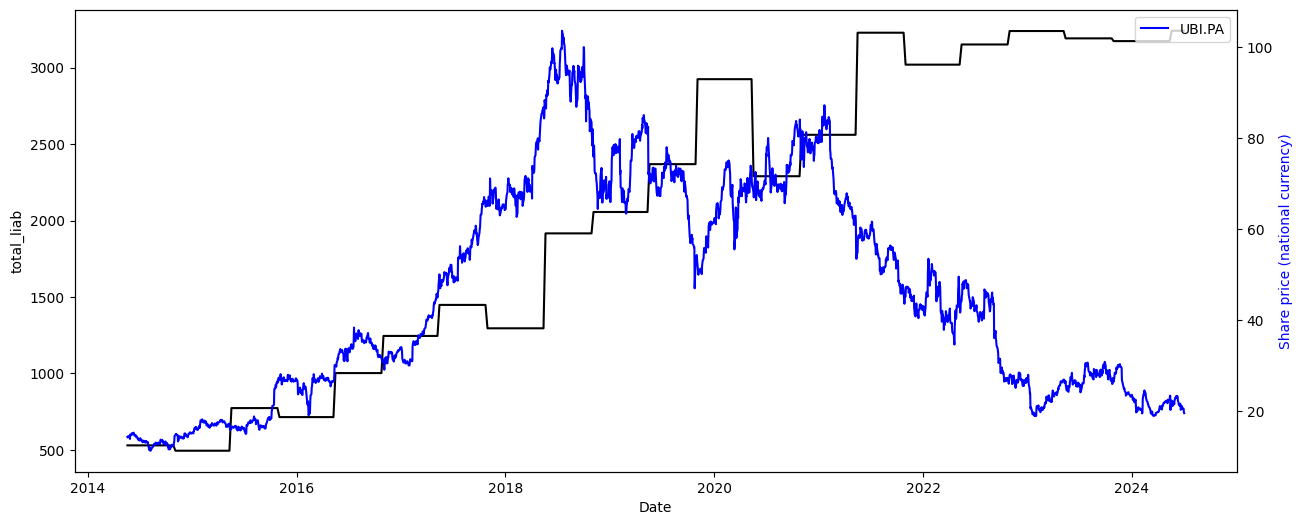

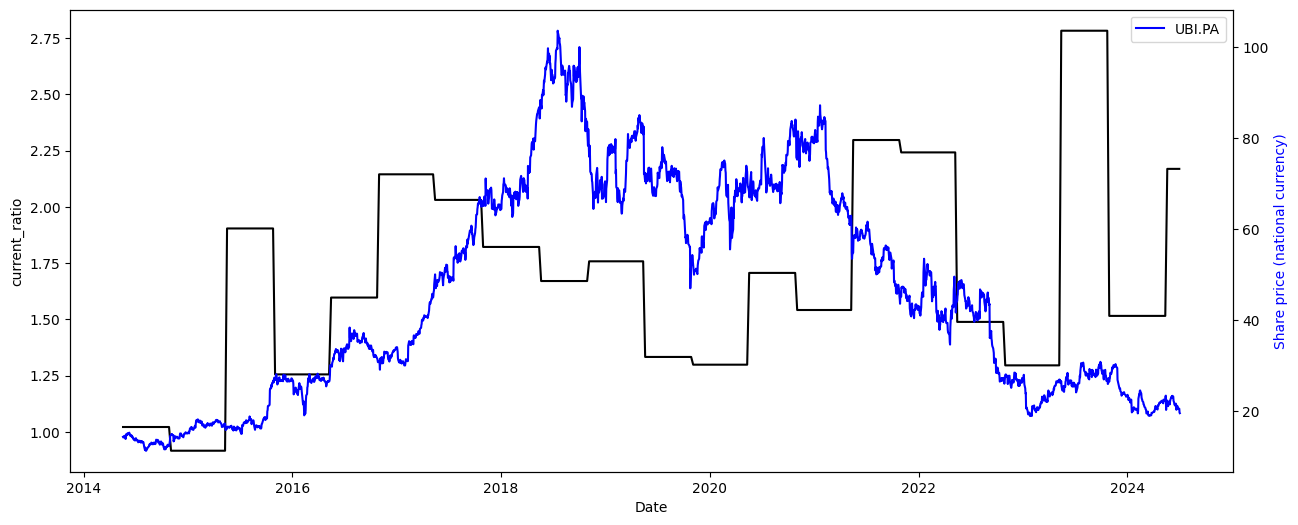

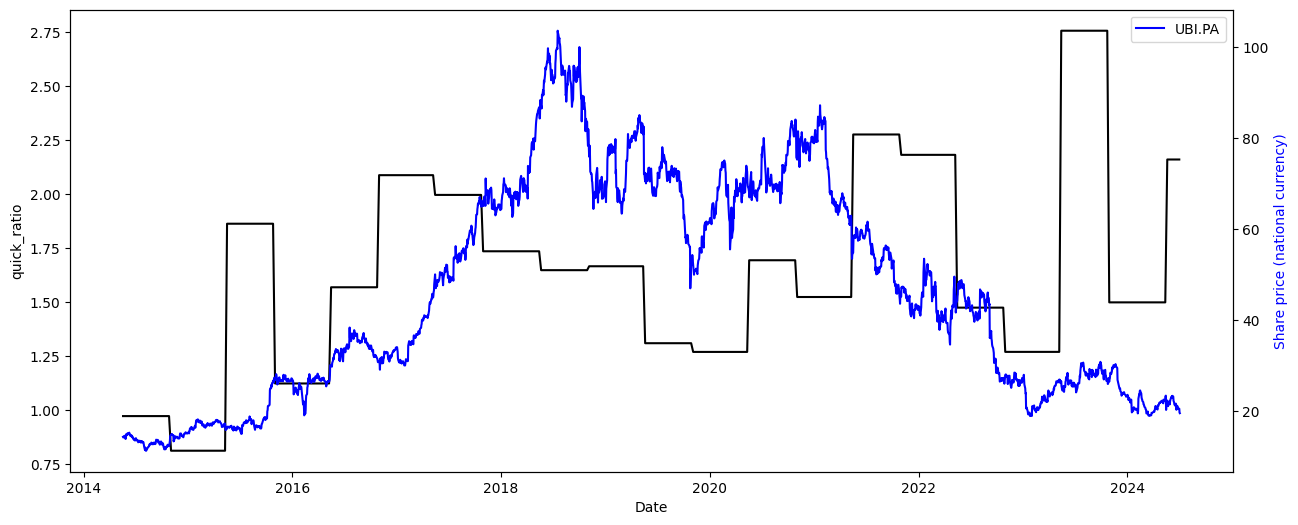

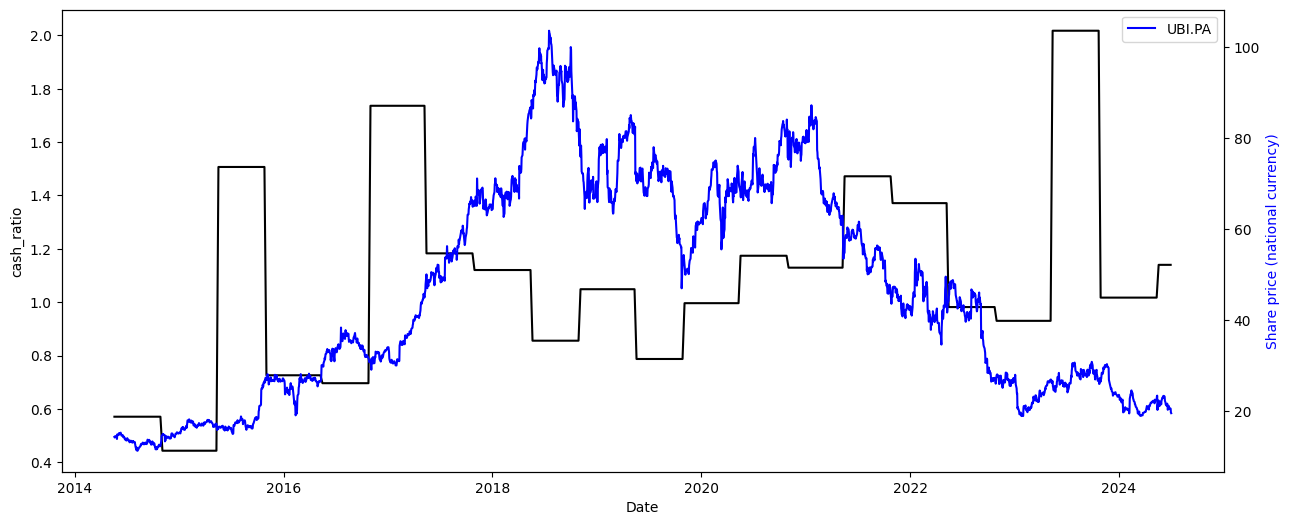

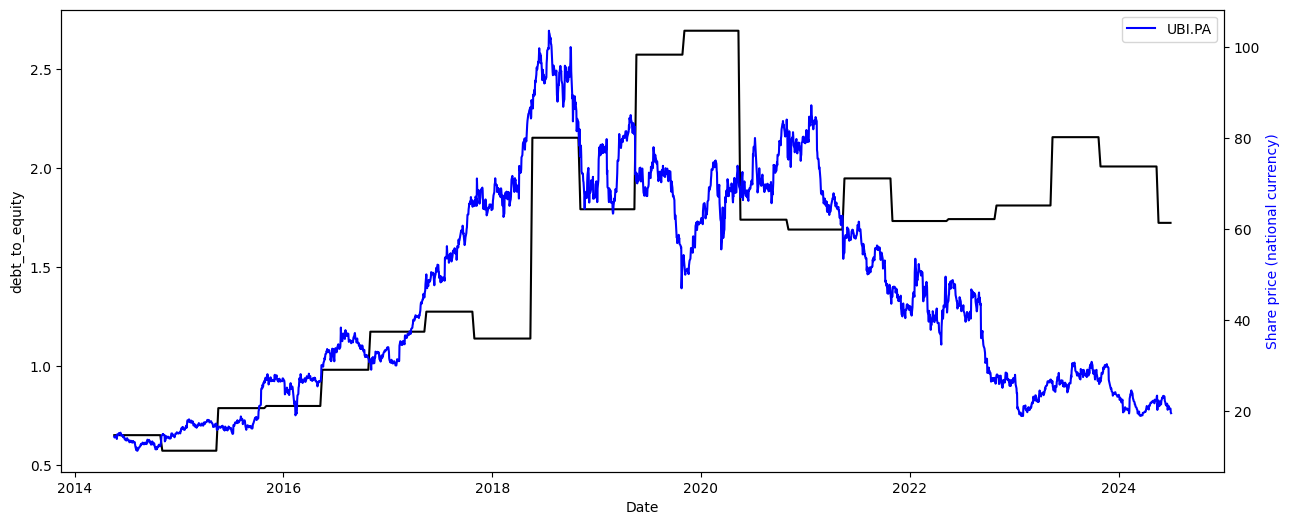

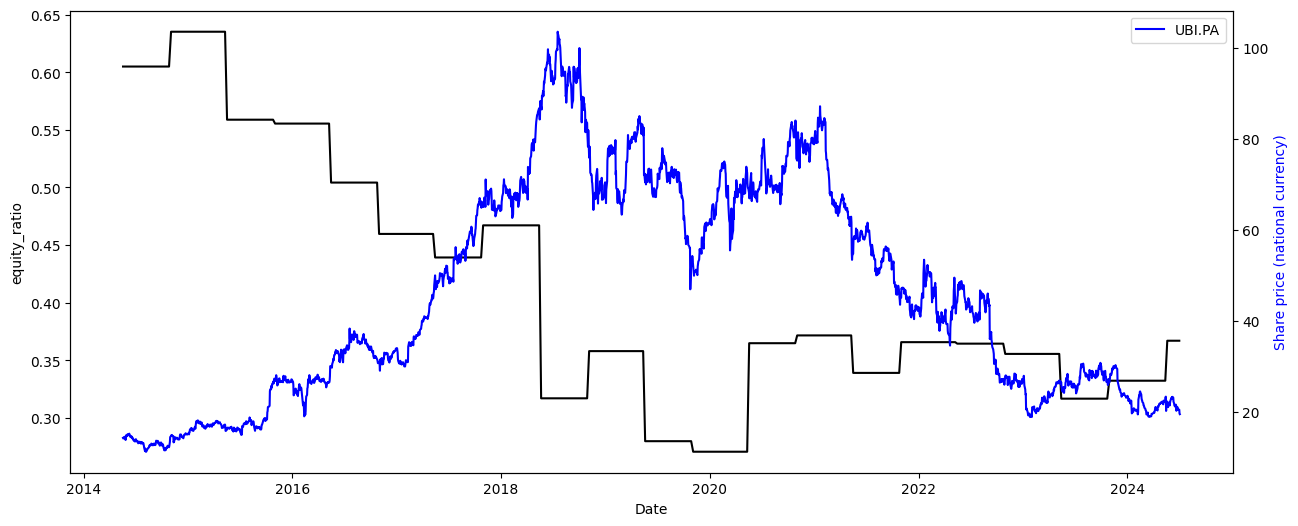

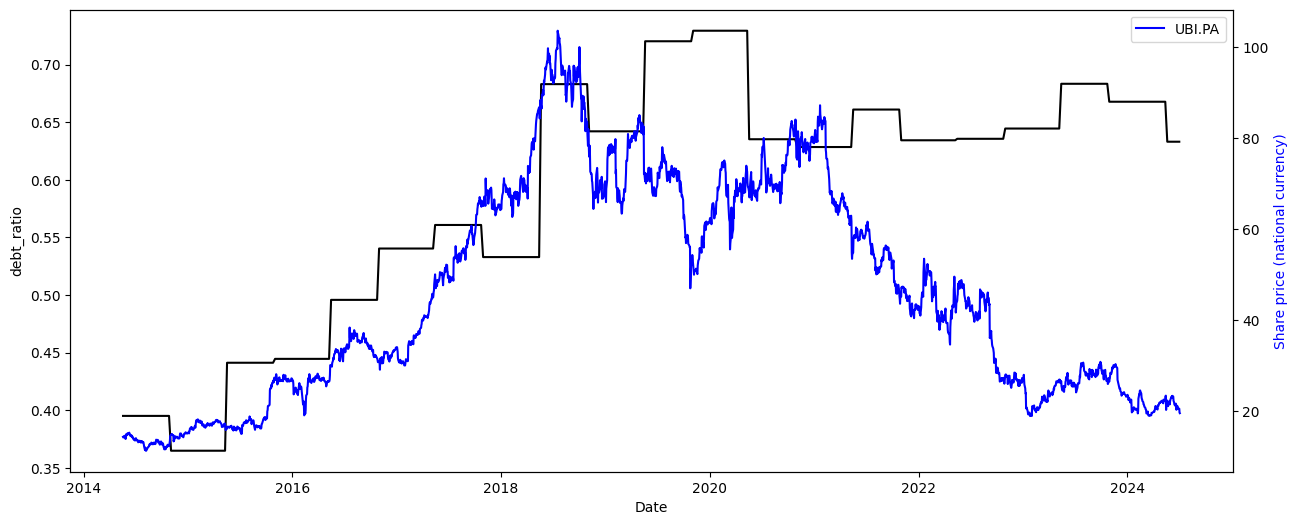

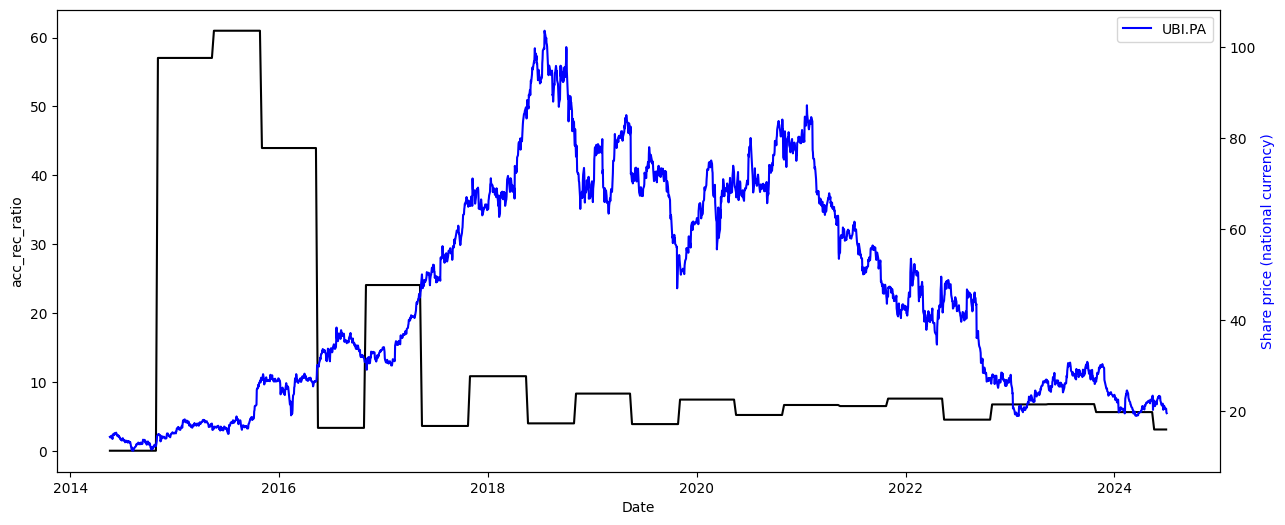

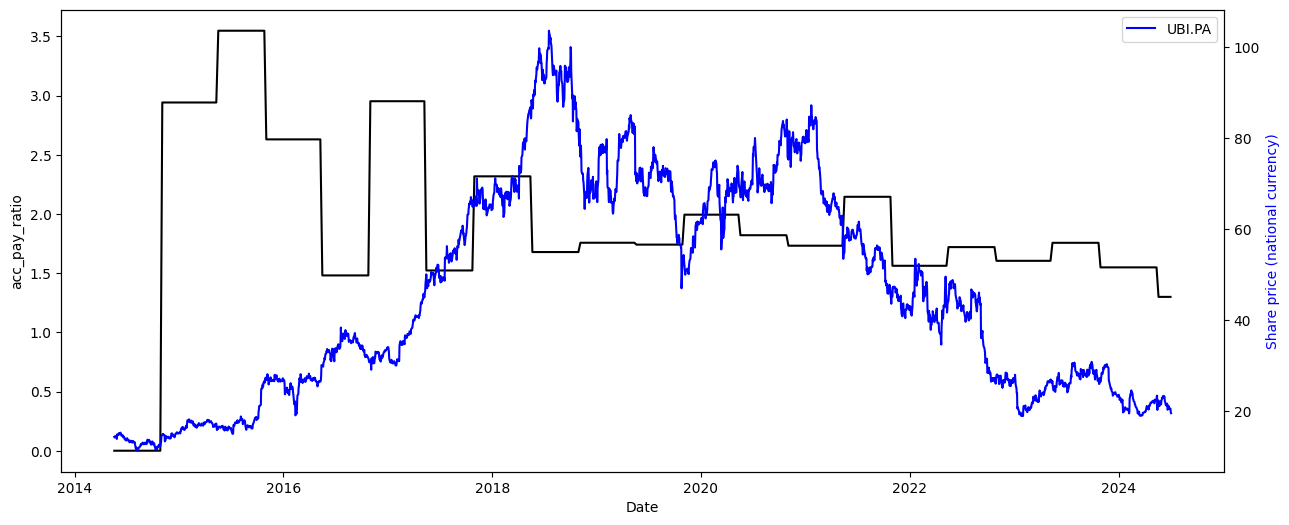

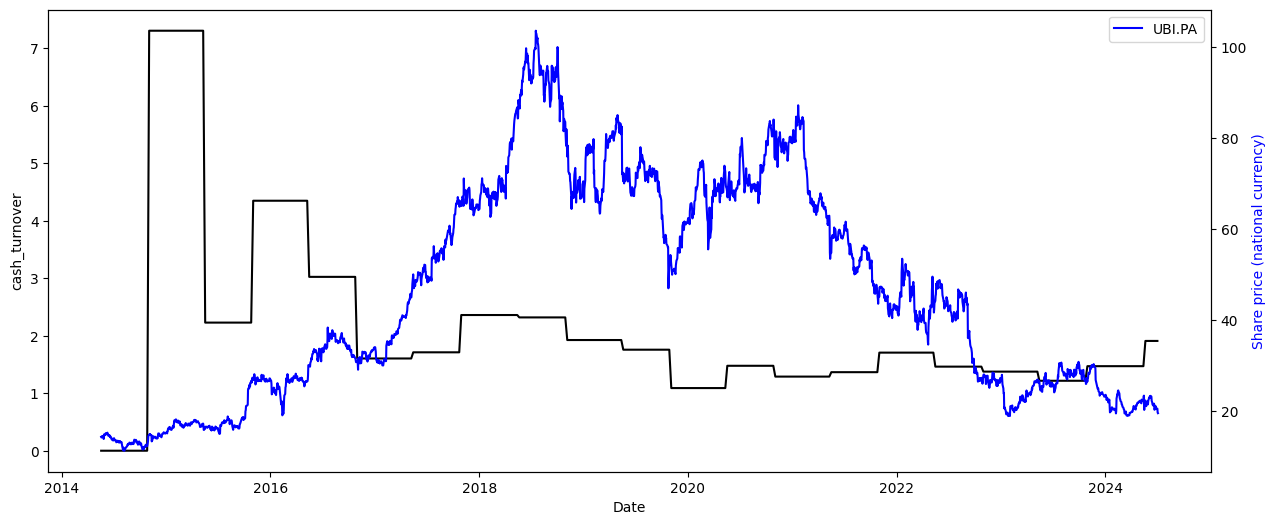

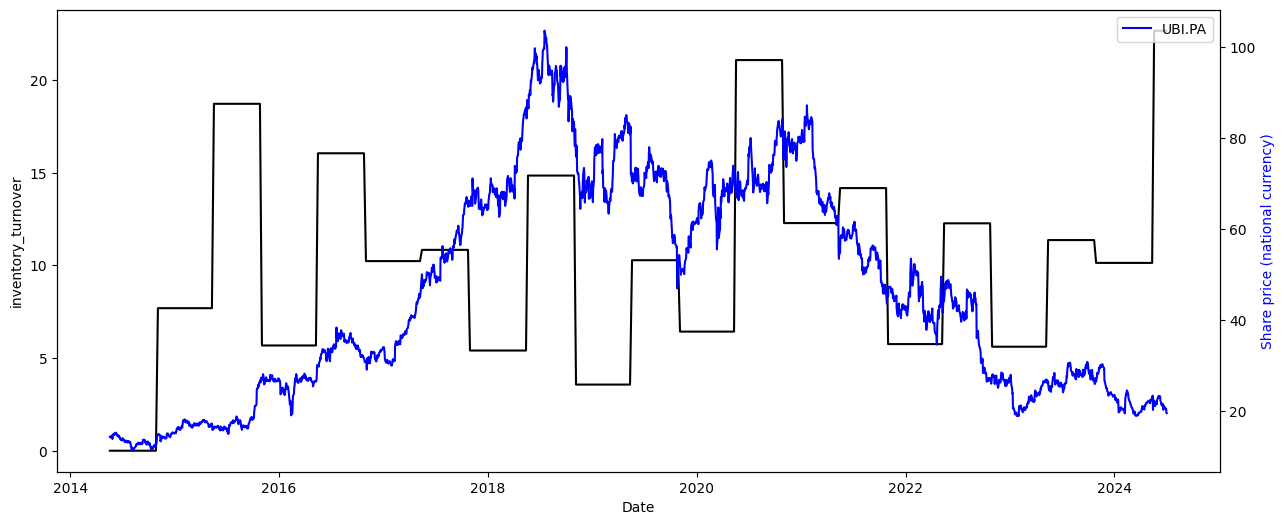

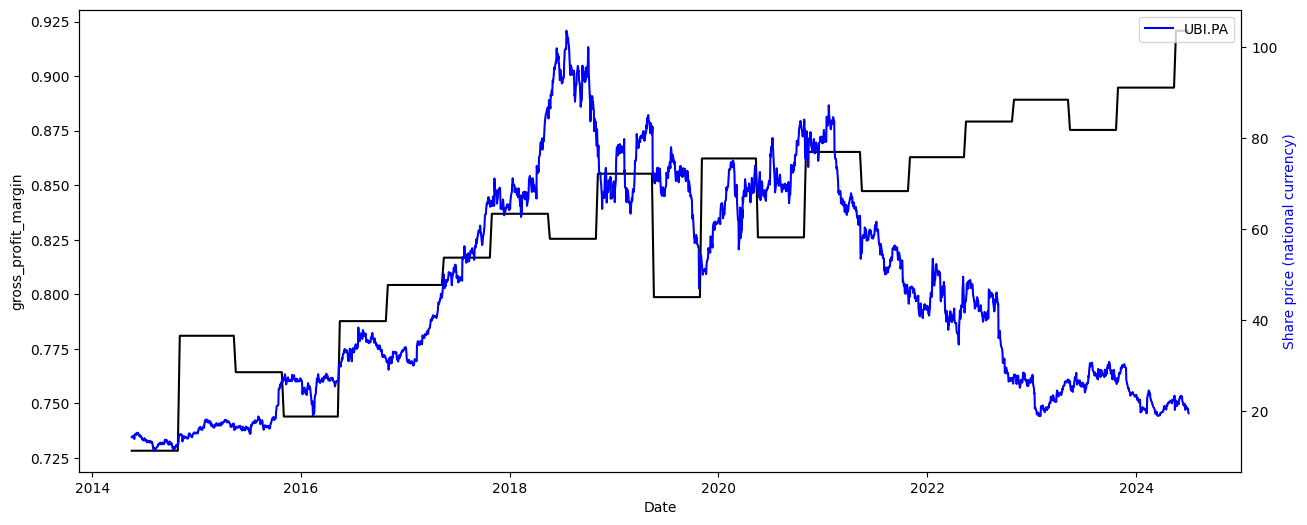

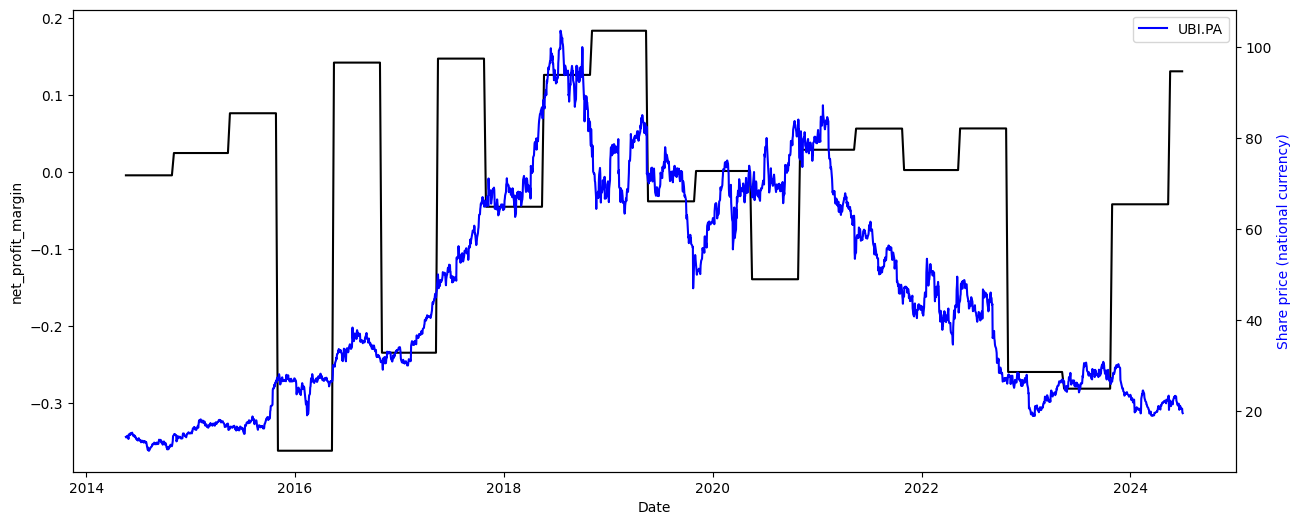

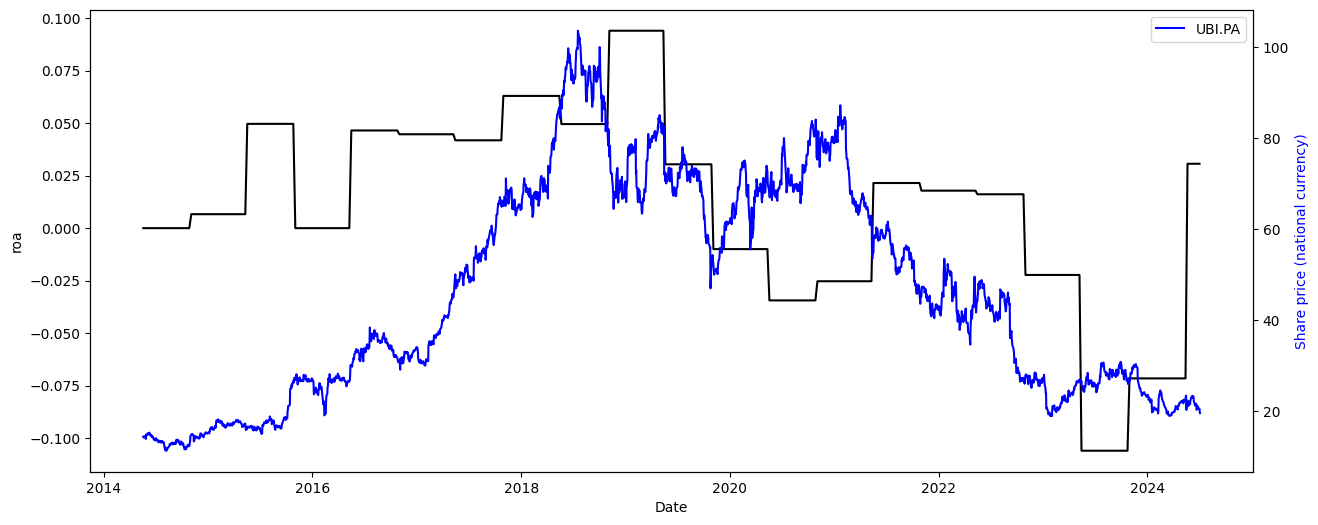

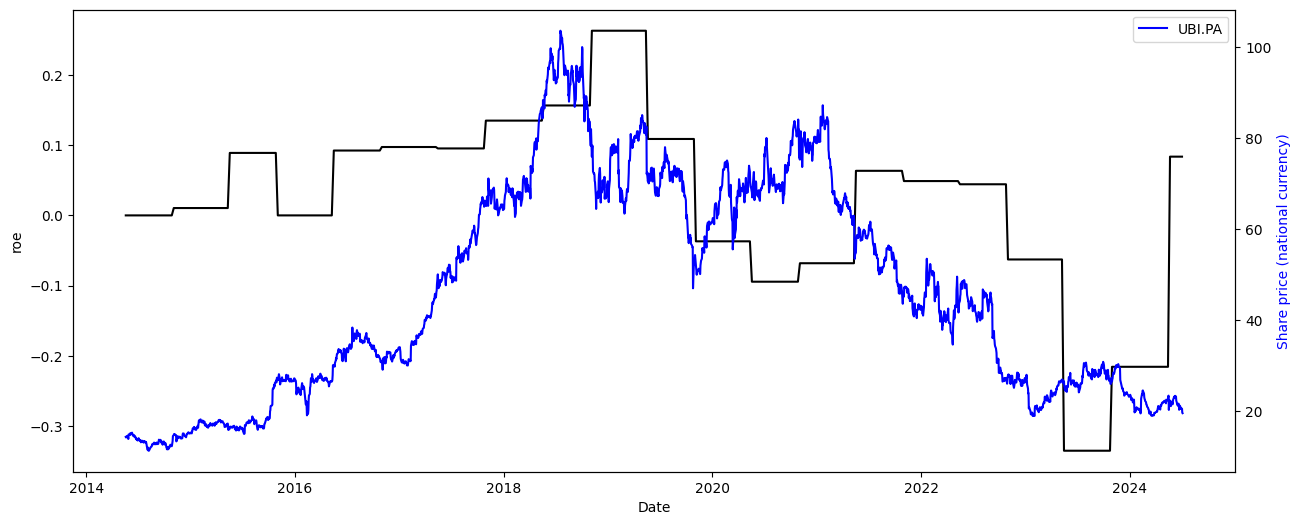

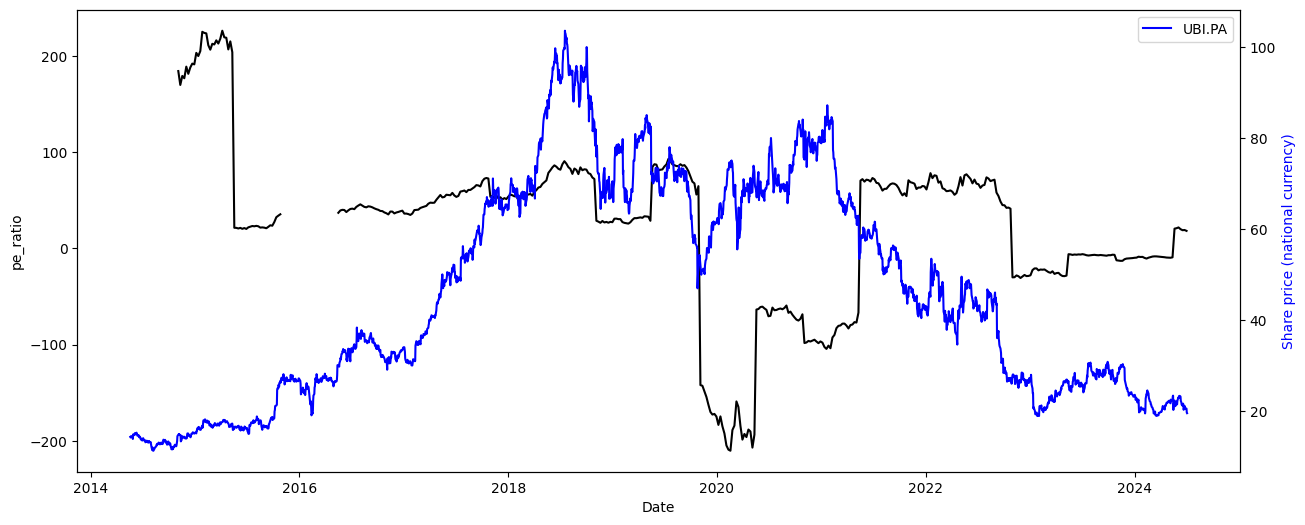

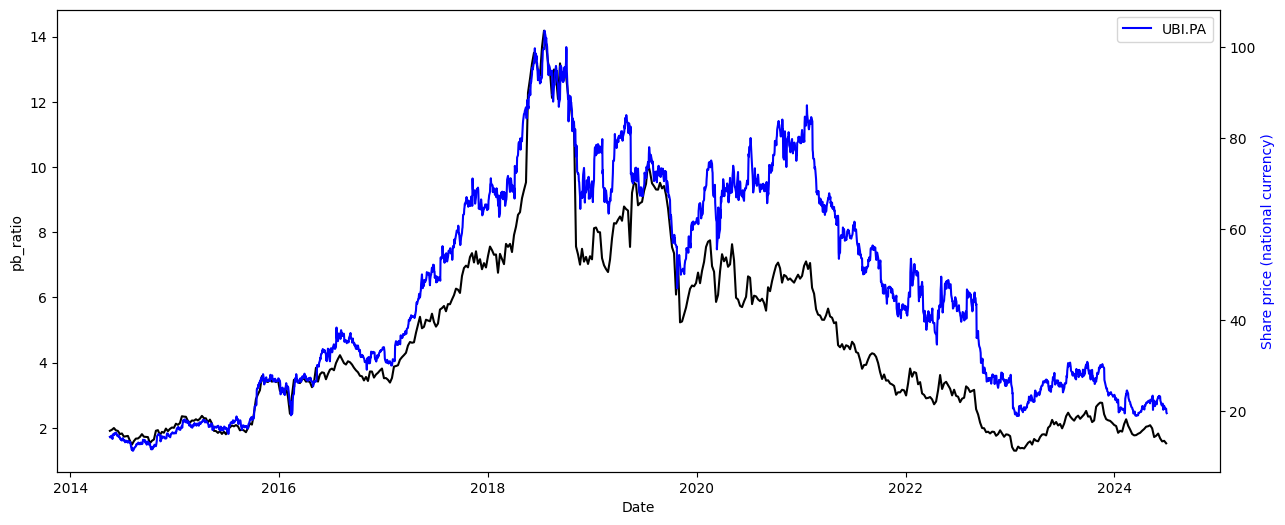

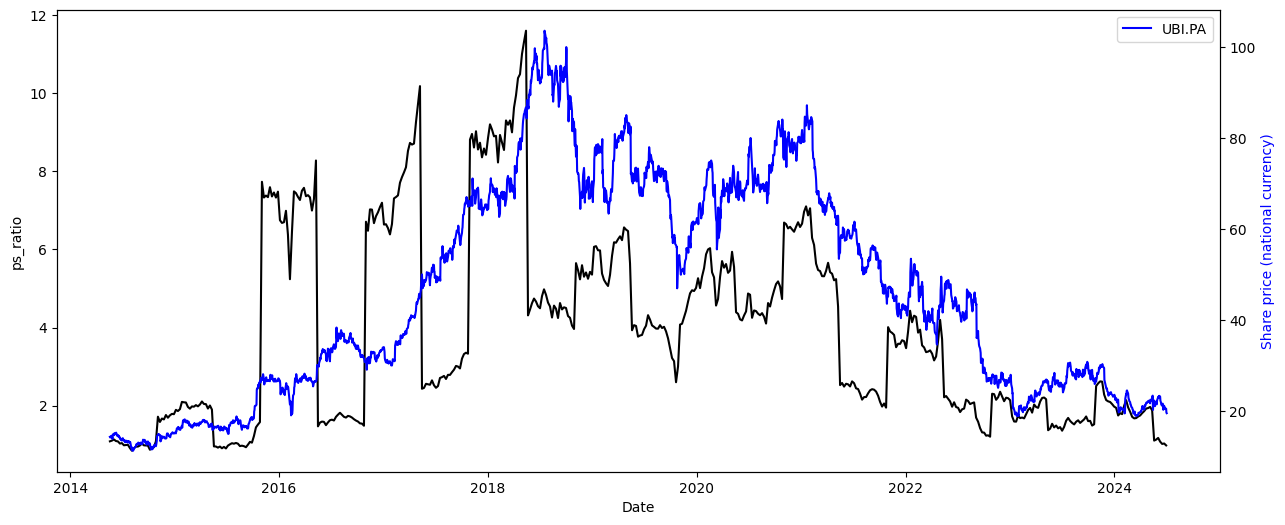

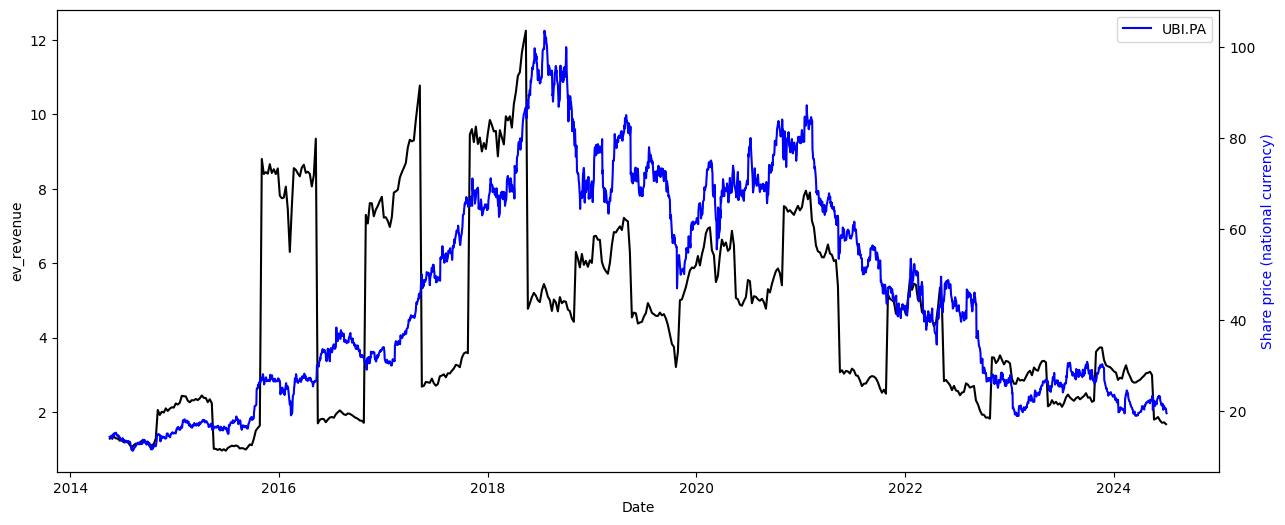

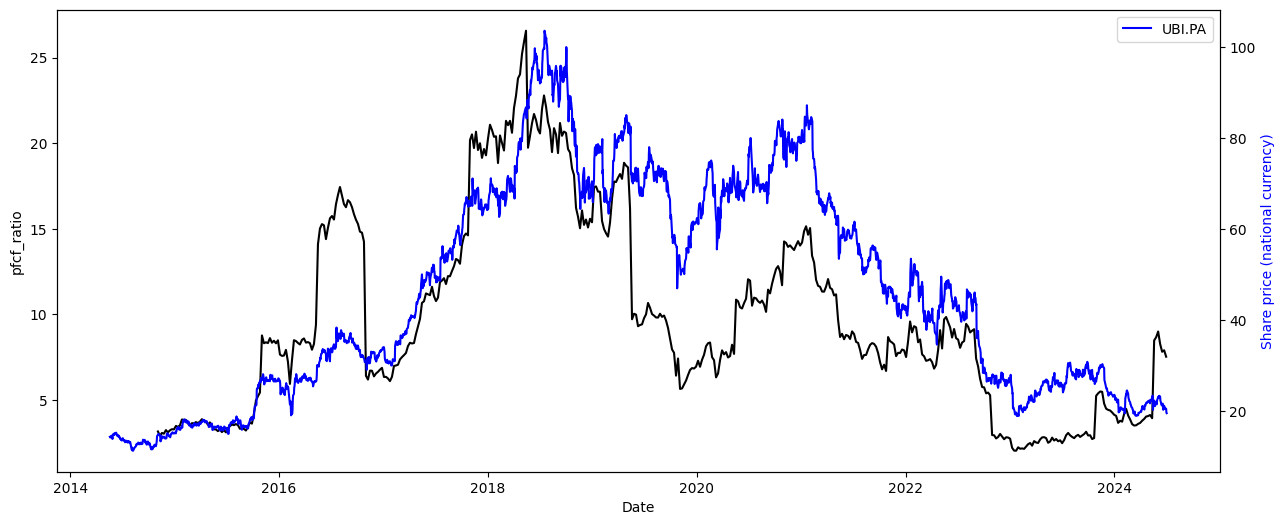

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

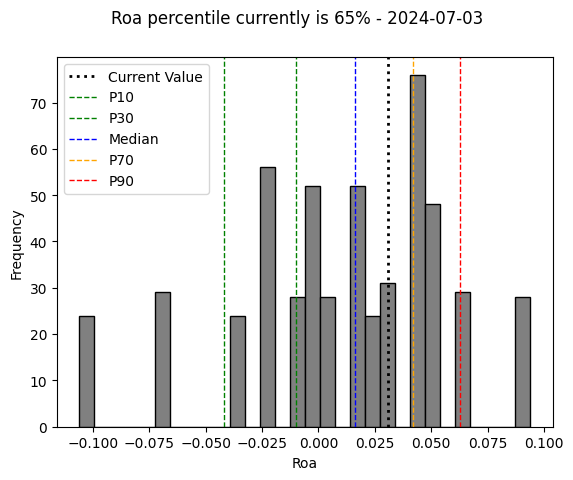

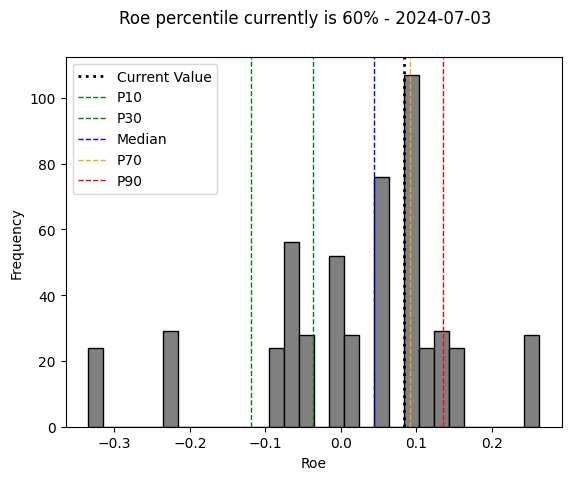

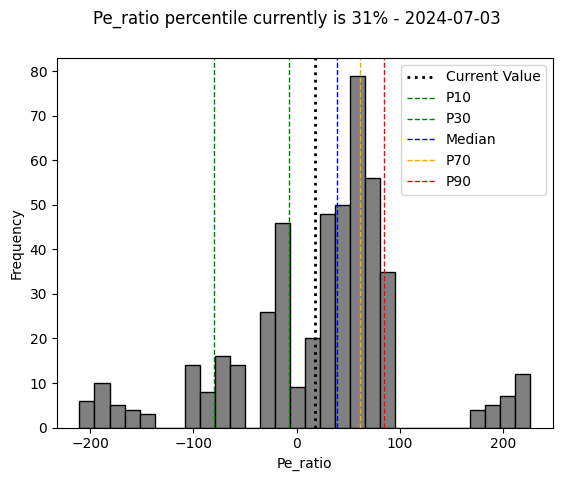

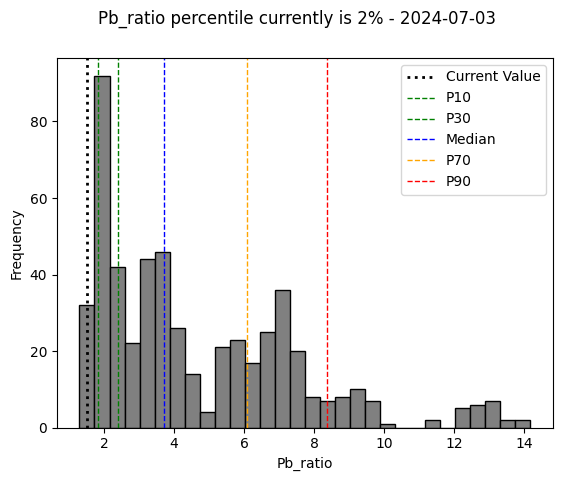

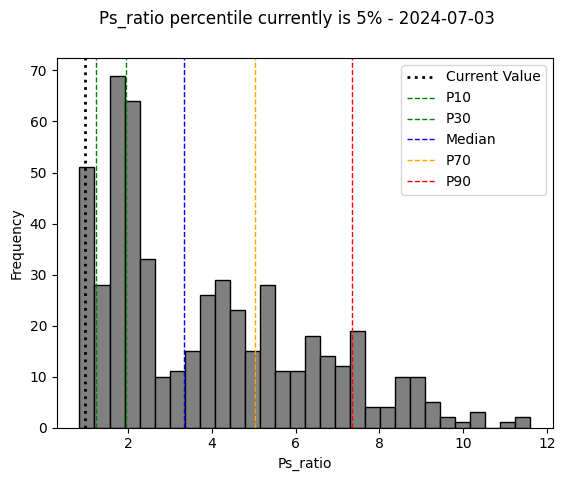

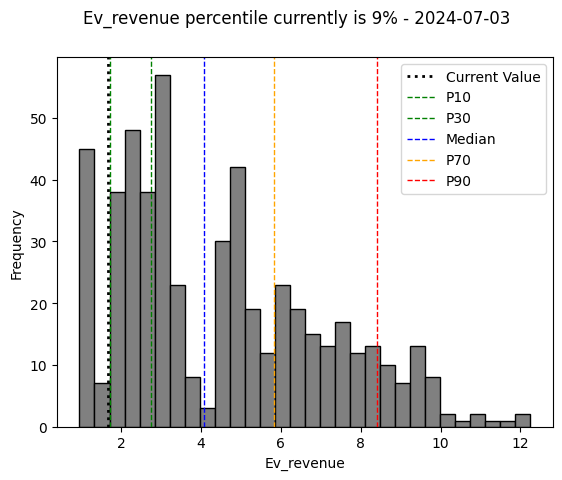

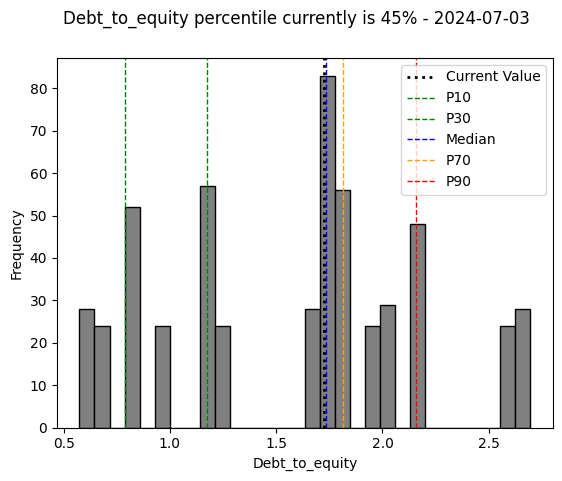

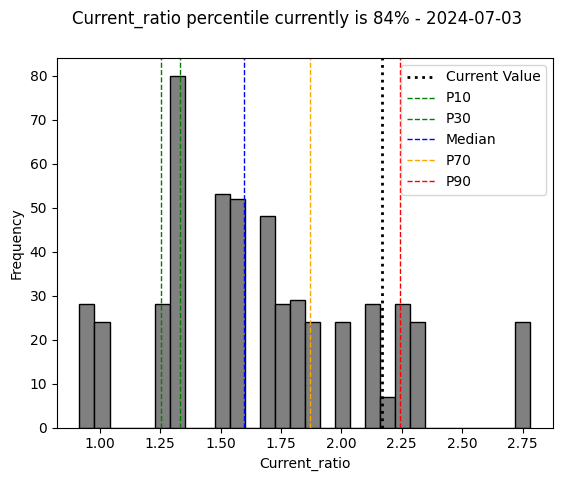

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989090,0.401598,0.433606,0.325551,0.251195,-0.279882,-0.022609
roe,0.989090,1.000000,0.399656,0.481389,0.323324,0.255175,-0.216281,-0.080382
pe_ratio,0.401598,0.399656,1.000000,-0.053951,-0.186722,-0.241520,-0.530178,-0.008454
pb_ratio,0.433606,0.481389,-0.053951,1.000000,0.535591,0.500266,0.423831,0.015082
ps_ratio,0.325551,0.323324,-0.186722,0.535591,1.000000,0.992636,0.006092,0.041366
ev_revenue,0.251195,0.255175,-0.241520,0.500266,0.992636,1.000000,0.066230,0.041519
debt_to_equity,-0.279882,-0.216281,-0.530178,0.423831,0.006092,0.066230,1.000000,0.218767
current_ratio,-0.022609,-0.080382,-0.008454,0.015082,0.041366,0.041519,0.218767,1.000000


7 timestemos have been found!


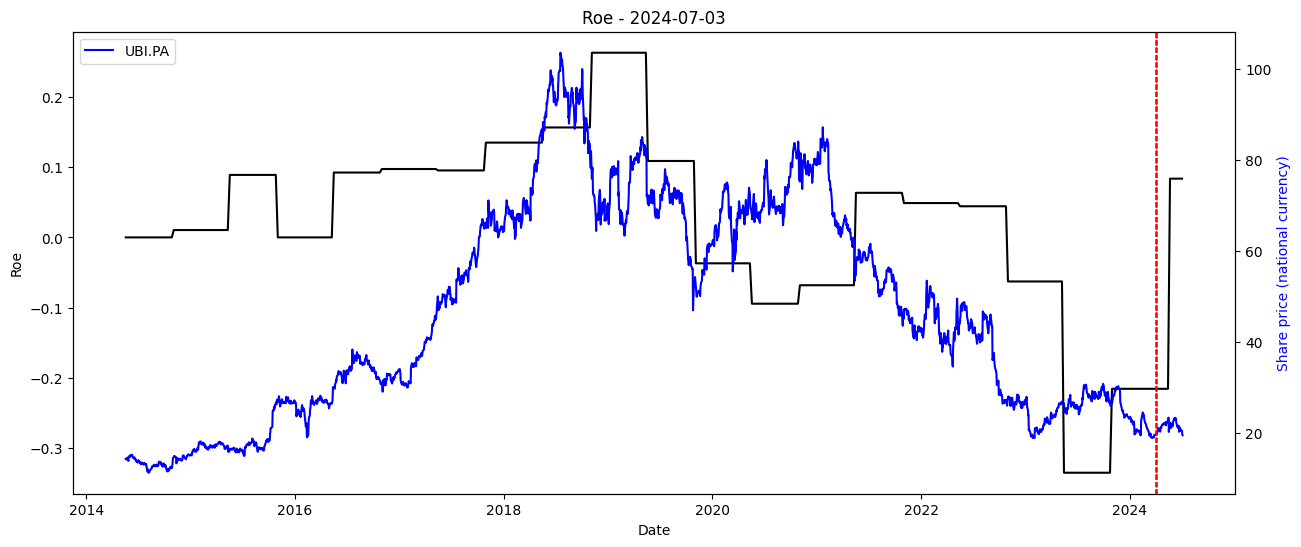

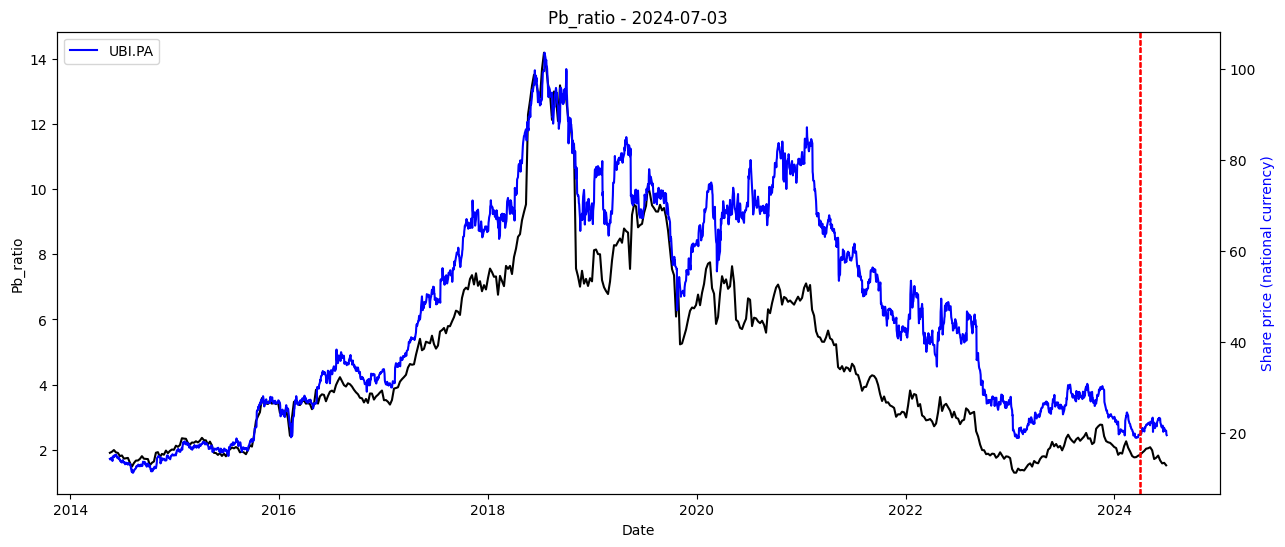

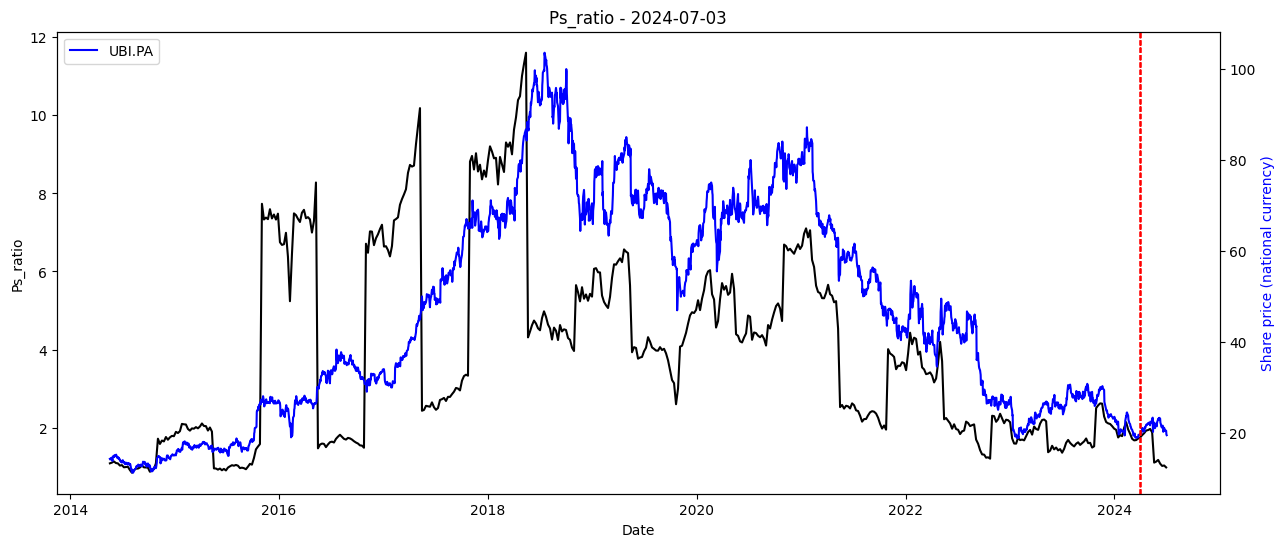

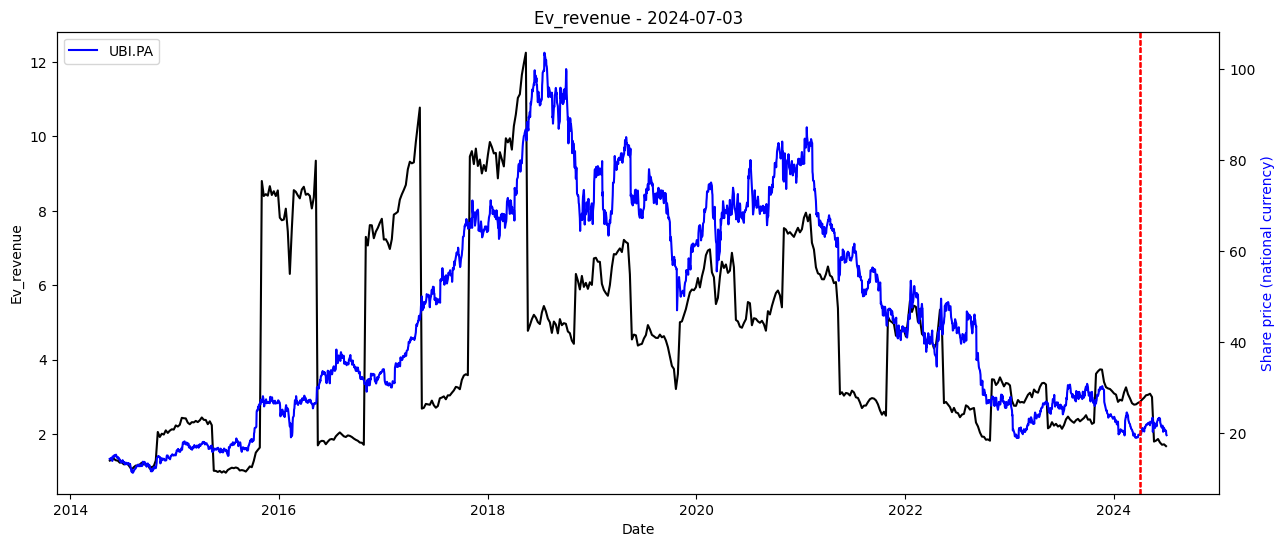

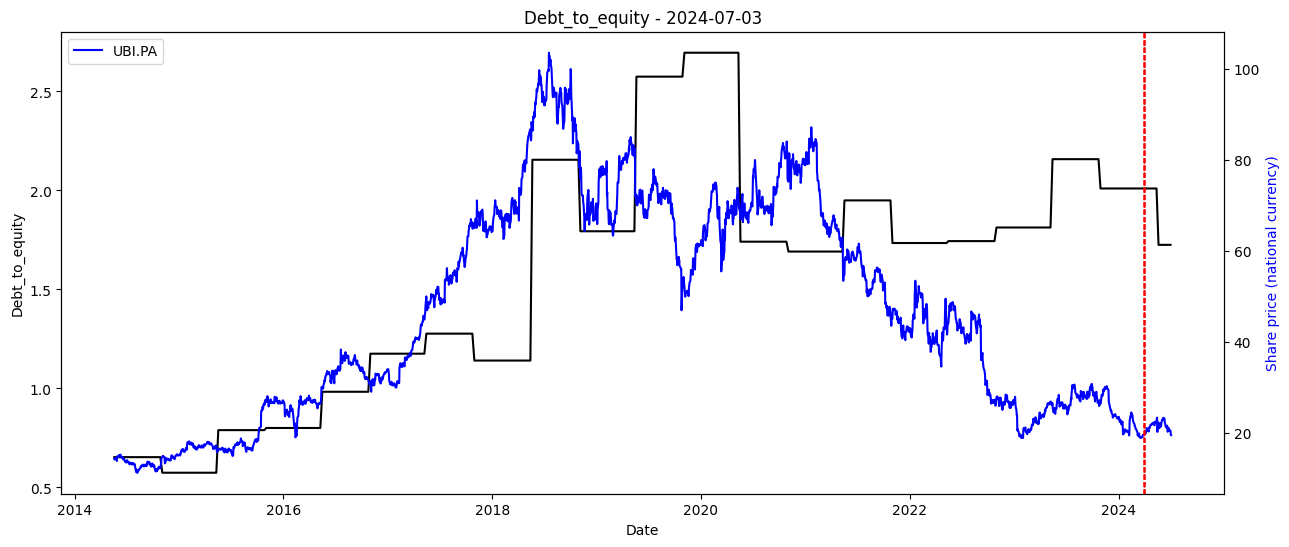

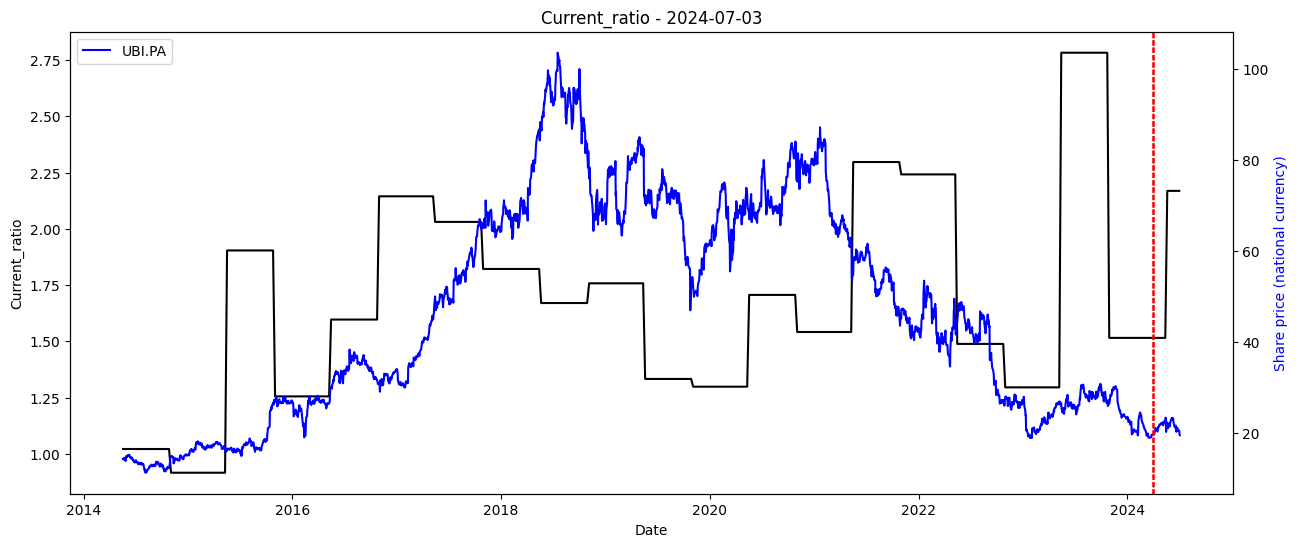

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )